<a href="https://colab.research.google.com/github/Manideep2k4/CROP-Recommendation/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn xgboost lightgbm catboost shap seaborn matplotlib joblib pytorch-tabnet torch

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

import joblib
import requests

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
KAGGLE_PATH = "/content/Crop_recommendation.csv"
INDIAN_PATH = "/content/indian crop.csv"
SHC_PATH    = "/content/final_crop_prediction_dataset.xlsx"

kaggle = pd.read_csv(KAGGLE_PATH)
indian = pd.read_csv(INDIAN_PATH)

print("Kaggle shape:", kaggle.shape)
print("Indian shape:", indian.shape)

indian = indian.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)


Kaggle shape: (2200, 8)
Indian shape: (2200, 8)


In [ ]:
FEATURE_COLS = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
LABEL_COL = "label"

# Combined encoder (very important)
encoder = LabelEncoder()
encoder.fit(pd.concat([kaggle[LABEL_COL], indian[LABEL_COL]], axis=0))

y_kag = encoder.transform(kaggle[LABEL_COL])
y_ind = encoder.transform(indian[LABEL_COL])

X_kag = kaggle[FEATURE_COLS].values
X_ind = indian[FEATURE_COLS].values

# Scaling
scaler = StandardScaler()
X_kag_scaled = scaler.fit_transform(X_kag)
X_ind_scaled = scaler.transform(X_ind)
#tabnet
X_kag_tab = X_kag_scaled.astype(np.float32)
y_kag_tab = y_kag.astype(np.int64)

X_ind_tab = X_ind_scaled.astype(np.float32)
y_ind_tab = y_ind.astype(np.int64)


# Domain adaptation noise
noise = np.random.normal(0, 0.10, X_ind_scaled.shape)
X_ind_noisy = X_ind_scaled + noise


In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_kag_scaled, y_kag)

xgb_model = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.9, eval_metric='mlogloss',
    random_state=RANDOM_STATE, n_jobs=-1
)
xgb_model.fit(X_kag_scaled, y_kag)

lgbm_model = LGBMClassifier(
    n_estimators=300, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    random_state=RANDOM_STATE
)
lgbm_model.fit(X_kag_scaled, y_kag)

cat = CatBoostClassifier(
    iterations=600, learning_rate=0.05, depth=8,
    verbose=0, random_state=RANDOM_STATE
)
cat.fit(X_kag_scaled, y_kag)

tabnet = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',  # better than sparsemax
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=10
)

tabnet.fit(
    X_train=X_kag_tab, y_train=y_kag_tab,
    eval_set=[(X_ind_tab, y_ind_tab)],
    eval_name=["indian"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=25,
    batch_size=256,
    virtual_batch_size=128,
    drop_last=False
)

print("Base models trained.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 7
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] 

In [ ]:
meta_features = np.hstack([
    rf.predict_proba(X_ind_noisy),
    xgb_model.predict_proba(X_ind_noisy),
    lgbm_model.predict_proba(X_ind_noisy),
    cat.predict_proba(X_ind_noisy),
    tabnet.predict_proba(X_ind_tab)
])

print("Meta-feature shape:", meta_features.shape)


Meta-feature shape: (2200, 110)


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_acc, cv_f1 = [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(meta_features, y_ind)):
    X_train, X_test = meta_features[train_idx], meta_features[test_idx]
    y_train, y_test = y_ind[train_idx], y_ind[test_idx]

    meta_clf = LGBMClassifier(
        n_estimators=600, learning_rate=0.03,
        max_depth=6, num_leaves=40,
        subsample=0.9, colsample_bytree=0.8,
        reg_lambda=2, reg_alpha=1, random_state=RANDOM_STATE
    )

    meta_clf.fit(X_train, y_train)
    pred = meta_clf.predict(X_test)

    cv_acc.append(accuracy_score(y_test, pred))
    cv_f1.append(f1_score(y_test, pred, average='macro'))

    print(f"Fold {fold+1} - Acc: {cv_acc[-1]:.3f}, F1: {cv_f1[-1]:.3f}")

print("\nMean CV Accuracy:", np.mean(cv_acc))
print("Mean CV Macro F1:", np.mean(cv_f1))


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_ind_noisy, y_ind, test_size=0.3, random_state=RANDOM_STATE, stratify=y_ind
)

meta_train = np.hstack([
    rf.predict_proba(X_train_raw),
    xgb_model.predict_proba(X_train_raw),
    lgbm_model.predict_proba(X_train_raw),
    cat.predict_proba(X_train_raw),
    tabnet.predict_proba(X_train_raw.astype(np.float32))
])

meta_test = np.hstack([
    rf.predict_proba(X_test_raw),
    xgb_model.predict_proba(X_test_raw),
    lgbm_model.predict_proba(X_test_raw),
    cat.predict_proba(X_test_raw),
    tabnet.predict_proba(X_test_raw.astype(np.float32))
])

final_clf = LGBMClassifier(
    n_estimators=600, learning_rate=0.03,
    max_depth=6, num_leaves=40,
    subsample=0.9, colsample_bytree=0.8,
    random_state=RANDOM_STATE
)
final_clf.fit(meta_train, y_train_raw)

pred = final_clf.predict(meta_test)
print("Final Accuracy:", accuracy_score(y_test_raw, pred))
print("Final F1:", f1_score(y_test_raw, pred, average='macro'))


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
models = {
    "rf": rf,
    "xgb": xgb_model,
    "lgbm": lgbm_model,
    "cat": cat,
    "tabnet": tabnet,
    "meta_clf": final_clf,
    "scaler": scaler,
    "label_encoder": encoder
}

joblib.dump(models, "final_tl_model.pkl")
print("Saved final_tl_model.pkl")


Saved final_tl_model.pkl


In [ ]:
shc = pd.read_excel(SHC_PATH)

def normalize_state(name):
    return name.lower().replace("_"," ").replace("-"," ").strip()

shc["State"] = shc["State"].apply(normalize_state)

default_N = shc["N"].median()
default_P = shc["P"].median()
default_K = shc["K"].median()
default_pH = shc["pH"].median()


In [ ]:
def clamp(v, mn, mx):
    return max(mn, min(mx, v))

In [ ]:
STATE_TO_CITY = {
    "andhra pradesh": "Vijayawada",
    "telangana": "Hyderabad",
    "karnataka": "Bengaluru",
    "tamil nadu": "Chennai",
    "kerala": "Thiruvananthapuram",
    "maharashtra": "Mumbai",
    "madhya pradesh": "Bhopal",
    "uttar pradesh": "Lucknow",
    "punjab": "Ludhiana",
    "haryana": "Gurgaon",
    "bihar": "Patna",
    "rajasthan": "Jaipur",
    "gujarat": "Ahmedabad",
    "west bengal": "Kolkata",
    "odisha": "Bhubaneswar",
    "assam": "Guwahati",
    "jharkhand": "Ranchi",
    "chhattisgarh": "Raipur"
}

API_KEY = "89f6bb05f824cf777e05a3da411c668f"

def get_weather(state_name):
    city = STATE_TO_CITY.get(normalize_state(state_name), state_name)

    try:
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
        r = requests.get(url, timeout=5)
        data = r.json()

        if "main" not in data:
            return 28.0, 65.0, 0.0

        temp = float(data["main"]["temp"])
        humidity = float(data["main"]["humidity"])
        rainfall = float(data.get("rain", {}).get("1h", 0.0))

        rainfall = rainfall * 24 * 30  # convert to monthly approx

        return temp, humidity, rainfall

    except:
        return 28.0, 65.0, 0.0


In [ ]:
def predict_crop(state, N, P, K, ph, rainfall=None, temperature=None, humidity=None):

    state_norm = normalize_state(state)

    N = clamp(N, 0, 500)
    P = clamp(P, 0, 500)
    K = clamp(K, 0, 500)
    ph = clamp(ph, 0, 14)

    row = shc[shc["State"] == state_norm]

    if not row.empty:
        N_state = row["N"].values[0]
        P_state = row["P"].values[0]
        K_state = row["K"].values[0]
        ph_state = row["pH"].values[0]
    else:
        N_state, P_state, K_state, ph_state = default_N, default_P, default_K, default_pH

    N_final = (N * 0.7) + (N_state * 0.3)
    P_final = (P * 0.7) + (P_state * 0.3)
    K_final = (K * 0.7) + (K_state * 0.3)
    ph_final = (ph * 0.7) + (ph_state * 0.3)

    if any(v is None for v in [temperature, humidity, rainfall]):
        temperature, humidity, rainfall = get_weather(state)

    if rainfall < 0.1:
        rainfall = 0.0

    X_user = np.array([[N_final, P_final, K_final, temperature, humidity, ph_final, rainfall]])

    X_scaled = scaler.transform(X_user)

    meta = np.hstack([
        rf.predict_proba(X_scaled),
        xgb_model.predict_proba(X_scaled),
        lgbm_model.predict_proba(X_scaled),
        cat.predict_proba(X_scaled),
        tabnet.predict_proba(X_scaled.astype(np.float32))
    ])

    pred = meta_clf.predict(meta)
    crop = encoder.inverse_transform(pred)[0]

    return {
        "state": state,
        "N_used": float(N_final),
        "P_used": float(P_final),
        "K_used": float(K_final),
        "pH_used": float(ph_final),
        "temperature": float(temperature),
        "humidity": float(humidity),
        "rainfall": float(rainfall),
        "recommended_crop": crop
    }


In [ ]:
result = predict_crop("Andhra Pradesh", 80, 40, 40, 6.5)
result

{'state': 'Andhra Pradesh',
 'N_used': 56.36472520794561,
 'P_used': 28.6862445373387,
 'K_used': 28.750211564437645,
 'pH_used': 5.167800859598853,
 'temperature': 20.78,
 'humidity': 75.0,
 'rainfall': 0.0,
 'recommended_crop': 'maize'}

In [ ]:
explain_matrix, masks = tabnet.explain(X_ind_tab)

In [ ]:
tabnet_feature_importance = tabnet.feature_importances_
print(tabnet_feature_importance)

[0.15692523 0.1357526  0.16023191 0.08200504 0.19833666 0.1018753
 0.16487326]


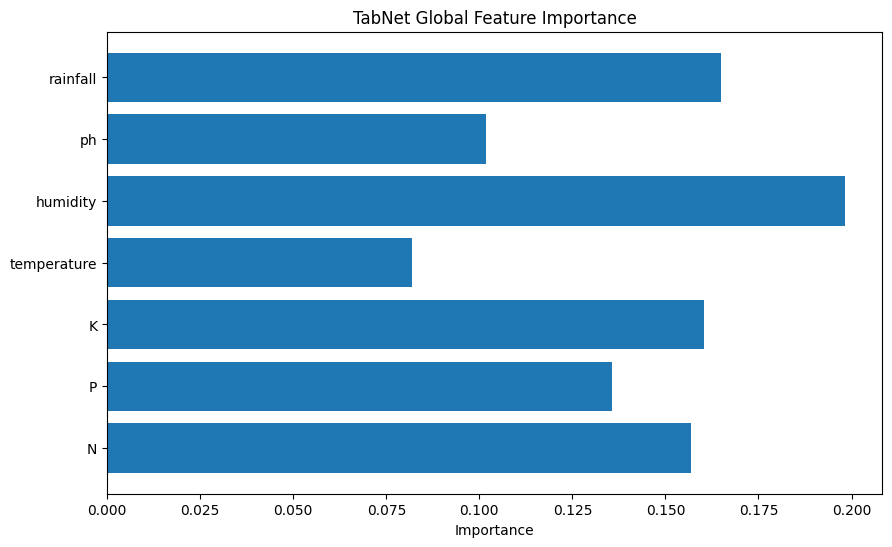

In [ ]:
import matplotlib.pyplot as plt

fi = tabnet.feature_importances_
feature_names = ["N","P","K","temperature","humidity","ph","rainfall"]

plt.figure(figsize=(10,6))
plt.barh(feature_names, fi)
plt.xlabel("Importance")
plt.title("TabNet Global Feature Importance")
plt.show()
